In [1]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

from matplotlib import colors
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import pandas as pd
sales_train_val = pd.read_csv('sales_train_validation.csv')
print(sales_train_val.head())

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  ...  d_1889

In [3]:
calendar = pd.read_csv('calendar.csv')
print(calendar.head())

         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  


In [4]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
calendar.dtypes

date            object
wm_yr_wk         int64
weekday         object
wday             int64
month            int64
year             int64
d               object
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA          int64
snap_TX          int64
snap_WI          int64
dtype: object

In [6]:
calendar = calendar.fillna(0)

In [7]:
sample_submission = pd.read_csv('sample_submission.csv')
print(sample_submission.head())

                              id  F1  F2  F3  F4  F5  F6  F7  F8  F9  F10  \
0  HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
1  HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
2  HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
3  HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0    0   
4  HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0    0   

   F11  F12  F13  F14  F15  F16  F17  F18  F19  F20  F21  F22  F23  F24  F25  \
0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

   F26  F27  F28  
0    0    0    0  
1    0    0    0  

In [8]:
sell_prices = pd.read_csv('sell_prices.csv')
print(sell_prices.head())

  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26


In [9]:
sales_train_validation = pd.read_csv('sales_train_validation.csv')
print(sales_train_validation)

                                  id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  \
0         CA_1       

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from itertools import cycle
pd.set_option('max_columns', 50) #컬럼 출력개수를 의미
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

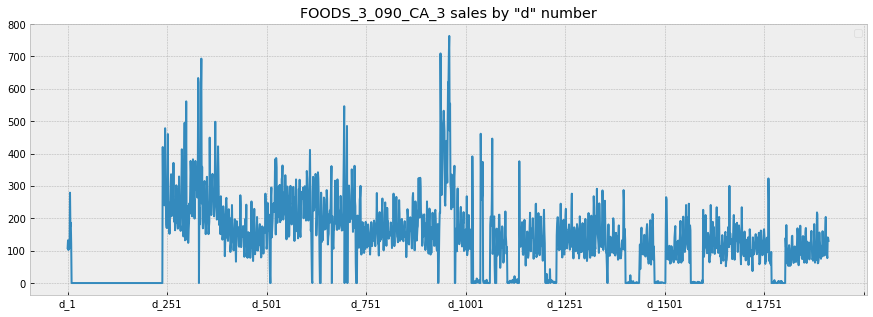

In [11]:
# extract sales data columns
d_cols = [c for c in sales_train_val.columns if 'd_' in c] # sales data columns
# print(d_cols)

sales_train_val.loc[sales_train_val['id'] == 'FOODS_3_090_CA_3_validation']\
  .set_index('id')[d_cols]\
  .T\
  .plot(figsize=(15,5), 
        title = 'FOODS_3_090_CA_3 sales by "d" number', color = next(color_cycle))
plt.legend('')
plt.show()

Merge

In [12]:
#2개의 데이터를 Merge 하도록 한다
temp = sales_train_val[sales_train_val['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
print(temp.head())

     8412
d_1   108
d_2   132
d_3   102
d_4   120
d_5   106


In [13]:
#8412의 column명을 FOODS_3_090_CA_3_validation로 변경한다. 참고로 FOODS_3_090은 제품에 대한 ID. Type, state and store.
#그리고 index에 d로 column명을 변경 한다.
temp = temp.rename(columns={8412:'FOODS_3_090_CA_3'}).reset_index().rename(columns={'index': 'd'})
print(temp.head())

     d  FOODS_3_090_CA_3
0  d_1               108
1  d_2               132
2  d_3               102
3  d_4               120
4  d_5               106


In [14]:
#calender 데이터셋과 Merge 한다.
temp = temp.merge(calendar, how='left', validate='1:1')
print(temp.head())

     d  FOODS_3_090_CA_3        date  wm_yr_wk    weekday  wday  month  year  \
0  d_1               108  2011-01-29     11101   Saturday     1      1  2011   
1  d_2               132  2011-01-30     11101     Sunday     2      1  2011   
2  d_3               102  2011-01-31     11101     Monday     3      1  2011   
3  d_4               120  2011-02-01     11101    Tuesday     4      2  2011   
4  d_5               106  2011-02-02     11101  Wednesday     5      2  2011   

  event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  \
0            0            0            0            0        0        0   
1            0            0            0            0        0        0   
2            0            0            0            0        0        0   
3            0            0            0            0        1        1   
4            0            0            0            0        1        0   

   snap_WI  
0        0  
1        0  
2        0  
3        0  
4  

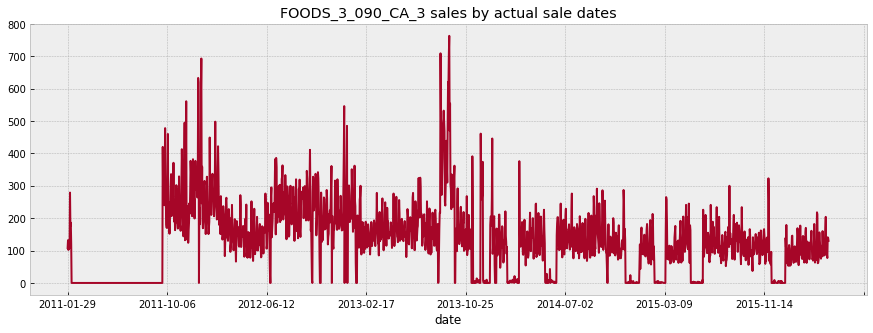

In [15]:
#날짜별 기준으로 FOODS_3_090_CA_3에 관한 그래프를 작성한다.
temp.set_index('date')['FOODS_3_090_CA_3']\
  .plot(figsize=(15,5), 
        color=next(color_cycle), 
        title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

In [16]:
# 이번에는 HOBBIES_1_234_CA_3에 대한 데이터를 Merge하여 시각화를 작성해보자. 
temp2 = sales_train_val[sales_train_val['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
temp2 = temp2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) # name it correctly
temp2 = temp2.reset_index().rename(columns={'index':'d'}) # make the index 'd'
temp2 = temp2.merge(calendar, how='left', validate='1:1')
print(temp2.head())

     d  HOBBIES_1_234_CA_3        date  wm_yr_wk    weekday  wday  month  \
0  d_1                   0  2011-01-29     11101   Saturday     1      1   
1  d_2                   0  2011-01-30     11101     Sunday     2      1   
2  d_3                   0  2011-01-31     11101     Monday     3      1   
3  d_4                   0  2011-02-01     11101    Tuesday     4      2   
4  d_5                   0  2011-02-02     11101  Wednesday     5      2   

   year event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  \
0  2011            0            0            0            0        0        0   
1  2011            0            0            0            0        0        0   
2  2011            0            0            0            0        0        0   
3  2011            0            0            0            0        1        1   
4  2011            0            0            0            0        1        0   

   snap_WI  
0        0  
1        0  
2        0  
3   

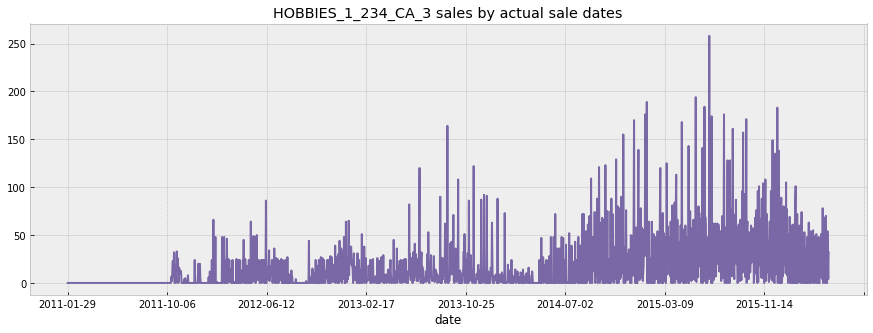

In [17]:
temp2.set_index('date')['HOBBIES_1_234_CA_3']\
  .plot(figsize=(15,5), 
        color=next(color_cycle), 
        title='HOBBIES_1_234_CA_3 sales by actual sale dates')
plt.show()

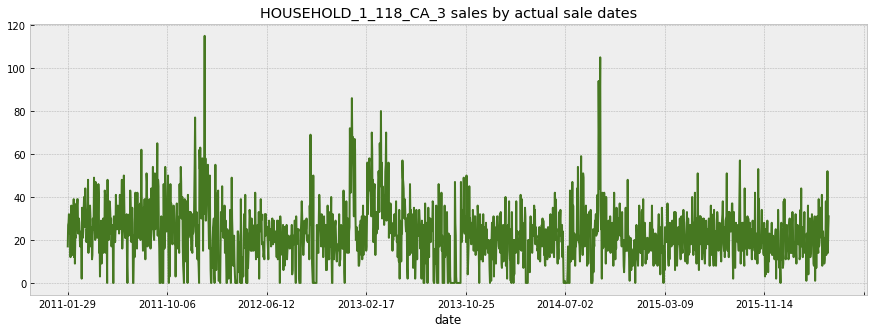

In [18]:
# 이번에는 HOUSEHOLD_1_118_CA_3_validation를 Merge 하여 시각화를 진행해보자.
temp3 = sales_train_val[sales_train_val['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
temp3 = temp3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # name it correctly
temp3 = temp3.reset_index().rename(columns={'index':'d'}) # make the index 'd'
temp3 = temp3.merge(calendar, how='left', validate='1:1')
temp3.set_index('date')['HOUSEHOLD_1_118_CA_3']\
  .plot(figsize=(15,5), 
        color=next(color_cycle), 
        title='HOUSEHOLD_1_118_CA_3 sales by actual sale dates')
plt.show()

연월 요일 기준으로 한 Sales 시각화

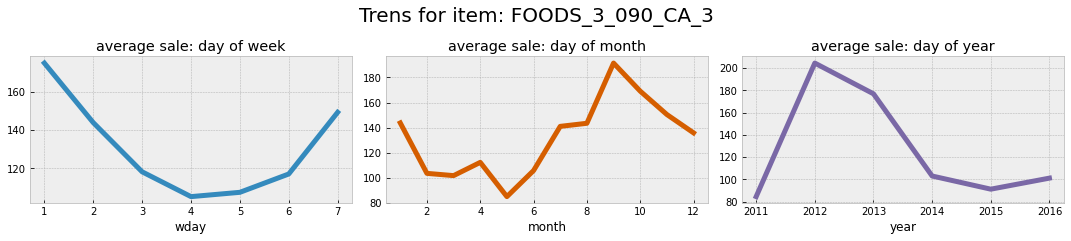

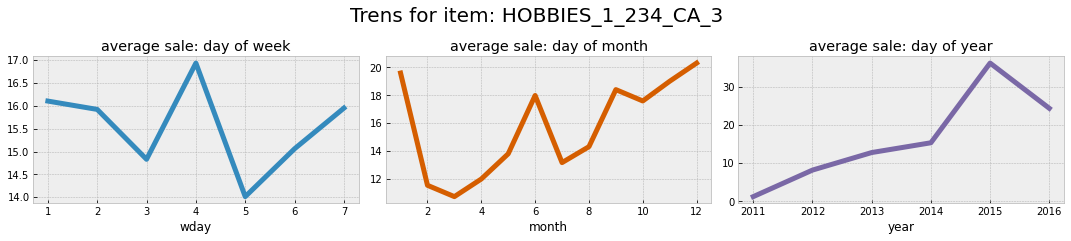

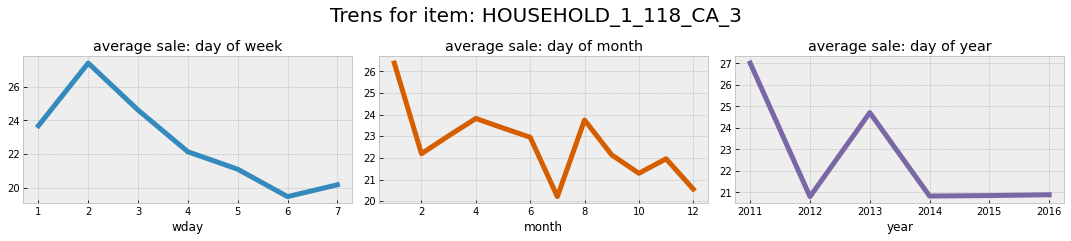

In [19]:
temps = ['FOODS_3_090_CA_3','HOBBIES_1_234_CA_3','HOUSEHOLD_1_118_CA_3']
temps_df = [temp, temp2, temp3]

for i in [0, 1, 2]:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3))
  # wday 시각화
  temps_df[i].groupby('wday').mean()[temps[i]]\
    .plot(kind='line', 
          title='average sale: day of week',
          lw = 5, 
          color=color_pal[0], 
          ax=ax1)
  
  # month 시각화
  temps_df[i].groupby('month').mean()[temps[i]]\
    .plot(kind='line', 
          title='average sale: day of month',
          lw = 5, 
          color=color_pal[4], 
          ax=ax2)
  
  # year 시각화
  temps_df[i].groupby('year').mean()[temps[i]]\
    .plot(kind='line', 
          title='average sale: day of year',
          lw = 5, 
          color=color_pal[2], 
          ax=ax3)

  # suptitle
  fig.suptitle(f'Trens for item: {temps[i]}', 
               size=20, 
               y=1.1)
  plt.tight_layout()
  plt.show()  

In [20]:
# tight_layout 함수는 각 데이터에 관한 여백(padding)에 관련된 subplot 파라미터를 조정한다.
# 위 3개의 item만 가지고 비교 했을 경우에는 HOBBIES_1_234_CA_3이 다른 두 아이템에 비해 평균적인 sales가 높은 것으로 확인되고 있다.

In [21]:
#Kaggle에서 데이터를 다운로드 받는 부분을 수행하였고, 이 부분을 통해서 이제 여러분들이 적극적으로 코드를 경험하기를 바란다.
#오늘 코드에서 중요한 부분은 서로 다른 데이터를 어떻게 Merge할 것인가가 핵심이고, 이 때 T라는 함수를 활용하여 행과 열을 transpose하는 것이 주요 핵심 사항이다.
#다음에는 sample item 30개를 조회해서 시각화를 구현하고, sector별로 판매개수 추이를 확인할 수 있는 시각화를 진행한다.

In [22]:
twenty_examples = sales_train_validation.sample(20, random_state=529) \
        .set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

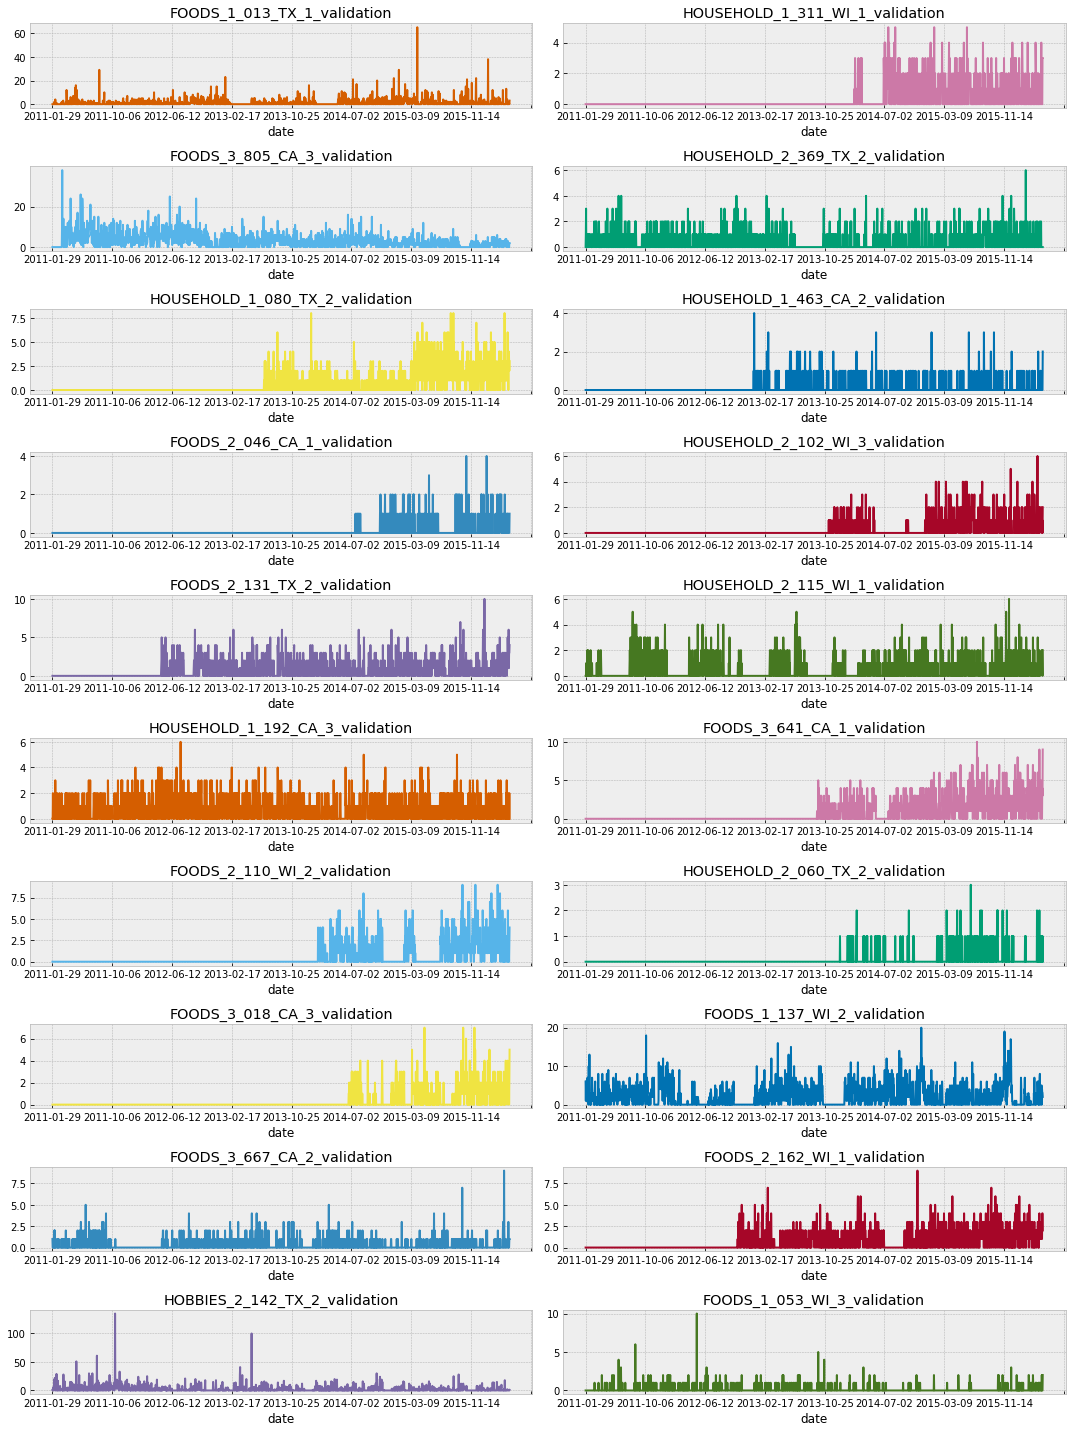

In [23]:
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

시간 경과에 따른 유형별 합산 매출액

In [24]:
sales_train_validation['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

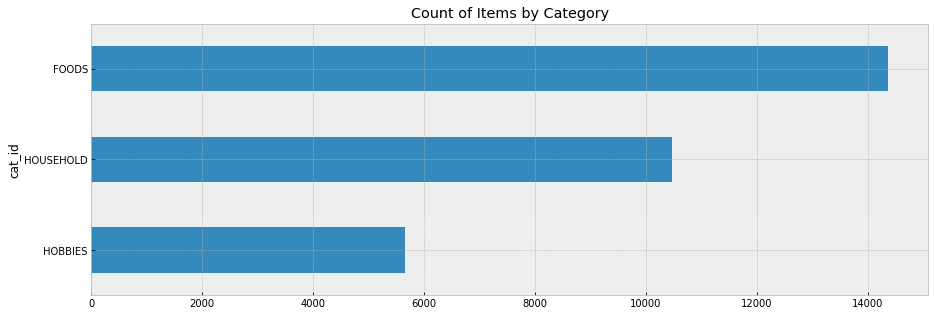

In [25]:
sales_train_validation.groupby('cat_id').count()['id'] \
    .sort_values() \
    .plot(kind='barh', figsize=(15, 5), title='Count of Items by Category')
plt.show()

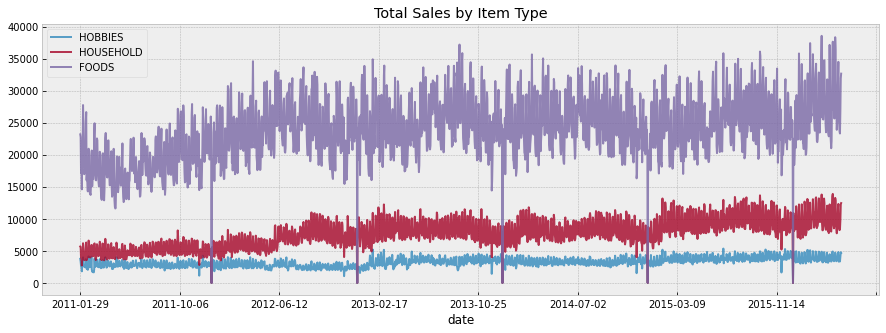

In [26]:
past_sales = sales_train_validation.set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Total Sales by Item Type')
plt.legend(sales_train_validation['cat_id'].unique())
plt.show()

판매중인 제품의 롤아웃

In [27]:
#우리는 이전에 존재하지 않았던 몇몇 품목들이 공급되는 것을 볼 수 있다. 마찬가지로 일부 품목은 판매를 완전히 중단합니다.
#판매를 표시하지만, 품목이 판매 중인지 판매 중인지 여부만 계산합니다(0 -> 판매 중 아님, >0 -> 판매 중).
#이 그림을 보면 많은 품목이 천천히 재고로 유입되고 있기 때문에 이들 중 많은 품목이 제공된 데이터의 시작 시점에 판매를 등록하지 않는다는 것을 알 수 있습니다.

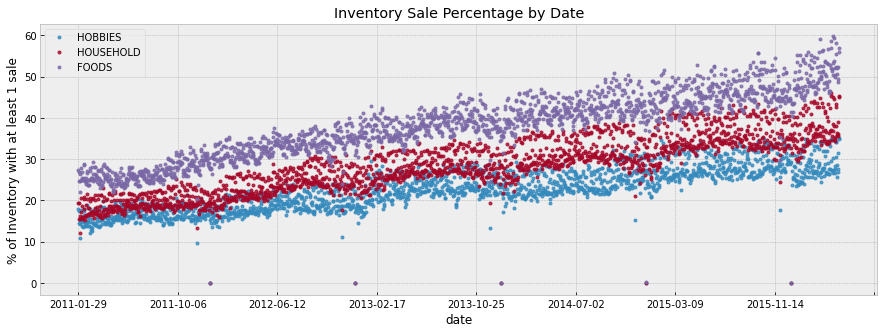

In [28]:
past_sales_clipped = past_sales.clip(0, 1)
for i in sales_train_validation['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    (past_sales_clipped[items_col] \
        .mean(axis=1) * 100) \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Inventory Sale Percentage by Date',
              style='.')
plt.ylabel('% of Inventory with at least 1 sale')
plt.legend(sales_train_validation['cat_id'].unique())
plt.show()

Sales by Store

In [29]:
#우리는 10개의 고유 매장에 대한 데이터를 제공합니다. 매장별 총 매출은 얼마인가요?
#일부 상점은 다른 상점보다 안정적입니다.
#CA_2는 2015년에 큰 변화가 있는 것 같습니다.

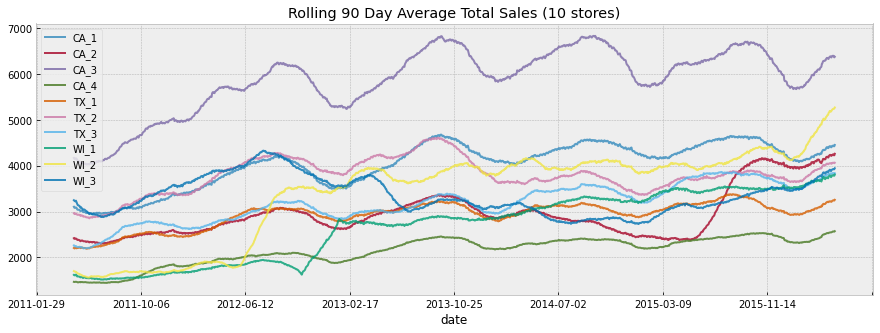

In [30]:
store_list = sell_prices['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

In [31]:
#동일한 데이터를 다른 방식으로 보면 스토어별 총 수요 카운트를 연속 7일 단위로 표시할 수 있습니다. 
#일부 점포의 수요 급변은 점포가 확장되거나 근처에 새로운 경쟁업체가 생긴 것일 수 있다는 점을 분명히 유의해야 한다. 
#어느 쪽이든 수요 패턴에 대한 예측 모델을 작성할 때 이 점을 유의해야 합니다.

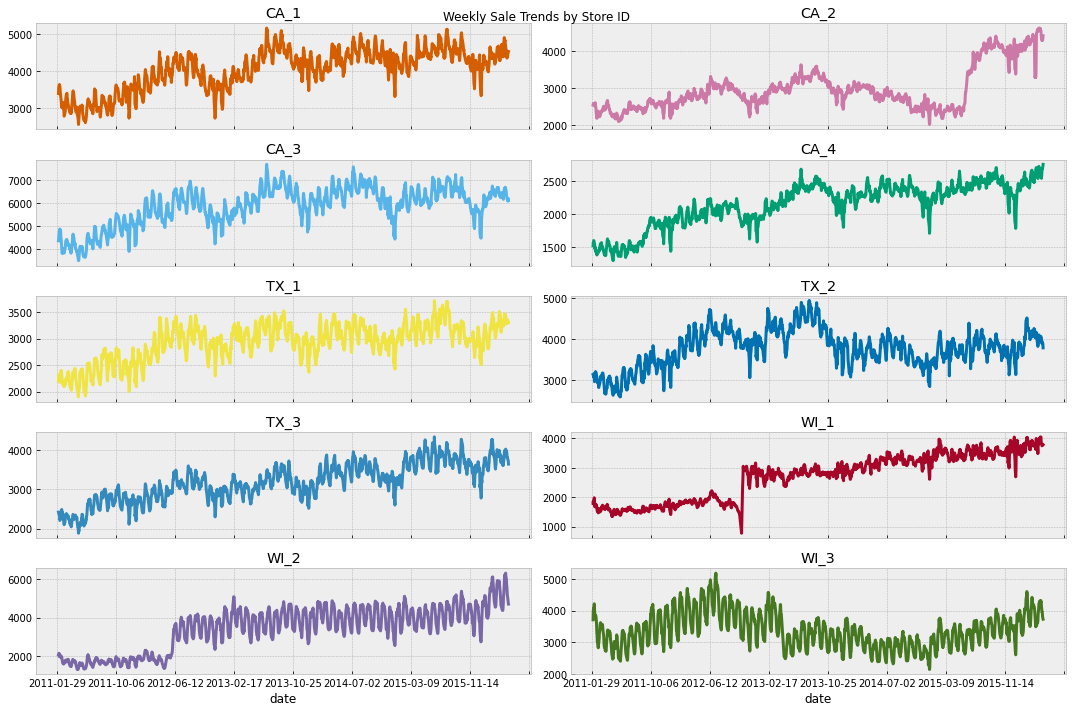

In [32]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()

Sales Heatmap Calendar

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from datetime import datetime
from dateutil.relativedelta import relativedelta


def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

In [34]:
#월마트는 크리스마스에 문을 닫는 것으로 보인다. 
#모든 데이터 중 수요가 가장 많았던 날은 2016년 3월 6일 일요일이었다. 
#이 날 무슨 일이 있었는지... CNN에 의해 주최되고 미시간 플린트에서 열린 7번째 민주당 대통령 후보 토론회... 
#매출에 영향을 미쳤는지 모르겠습니다만:D

In [35]:
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values().index[0],
     'with', past_sales.sum(axis=1).sort_values().values[0], 'sales')
print('The lowest sale date was:', past_sales.sum(axis=1).sort_values(ascending=False).index[0],
     'with', past_sales.sum(axis=1).sort_values(ascending=False).values[0], 'sales')


The lowest sale date was: 2012-12-25 with 11 sales
The lowest sale date was: 2016-03-06 with 57218 sales


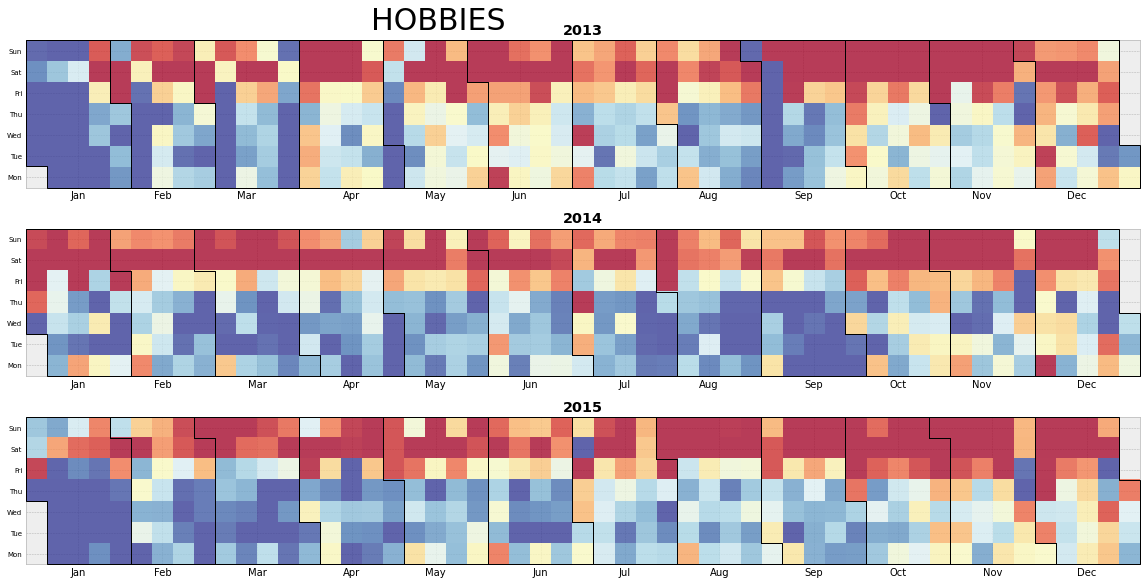

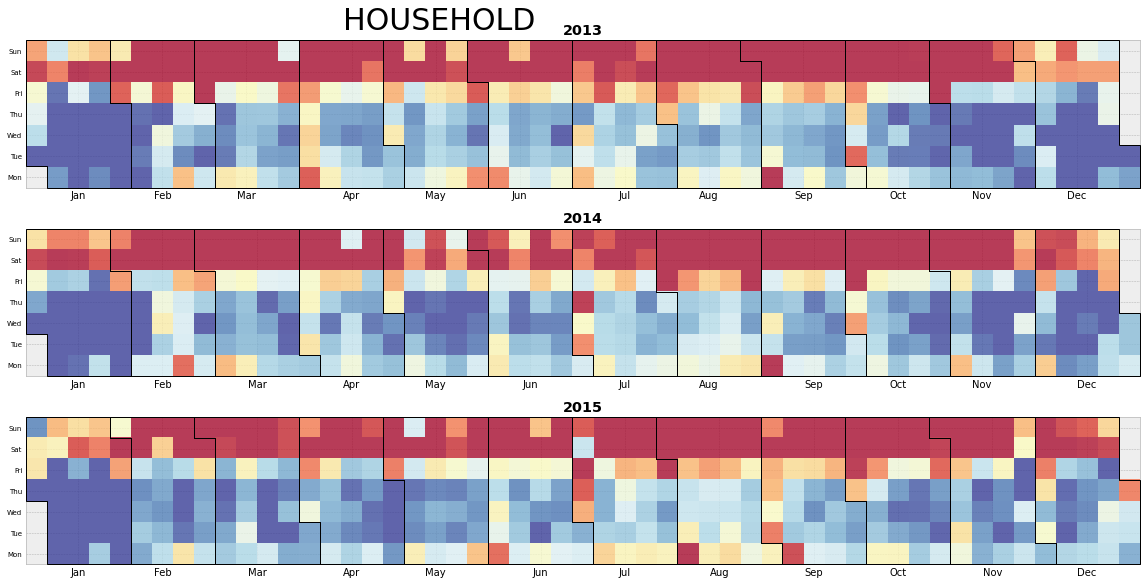

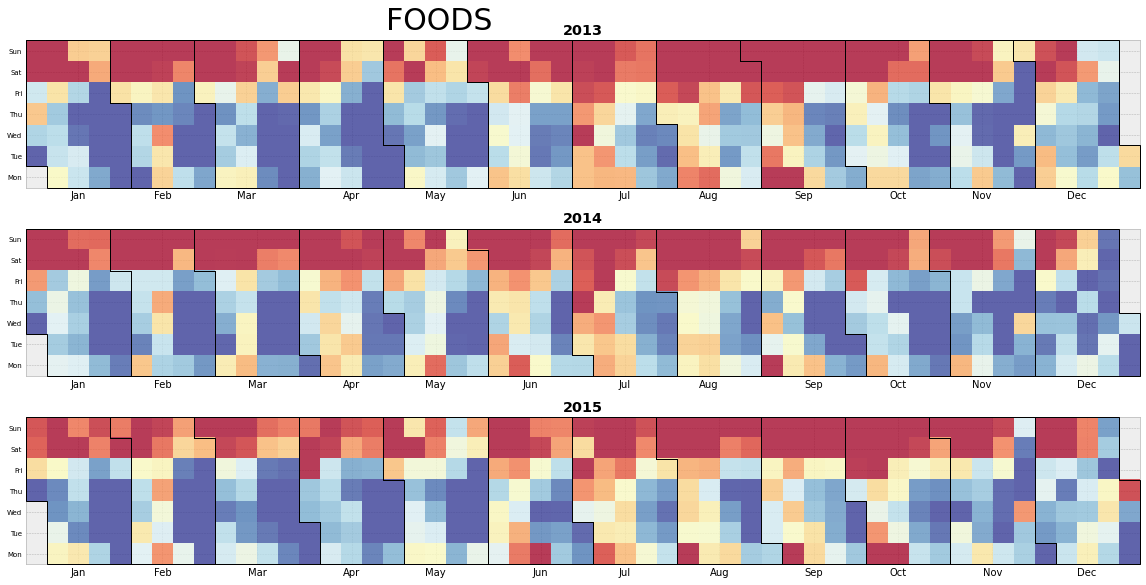

In [36]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in sales_train_validation['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(20, 8))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

In [37]:
#다음 열 지도에서 주의해야 할 몇 가지 흥미로운 사항은 다음과 같습니다.

#식품은 한 달이 지날수록 구매 횟수가 줄어드는 경향이 있다. 사람들이 월초에 월급을 받기 때문일까?
#가정용품과 취미용품은 홀리데이 시즌이 끝난 후인 1월에 훨씬 덜 팔린다.
#맑은 주말은 아이템 카테고리에 상관없이 쇼핑하는 날이 더 인기다.

Sale Price

In [38]:
#우리는 각 품목의 과거 판매 가격을 받는다. 이전 예제 항목을 살펴보겠습니다.

#내가 보기에 이 물건의 가격이 점점 오르고 있는 것 같다.
#가게마다 판매 가격이 다릅니다.

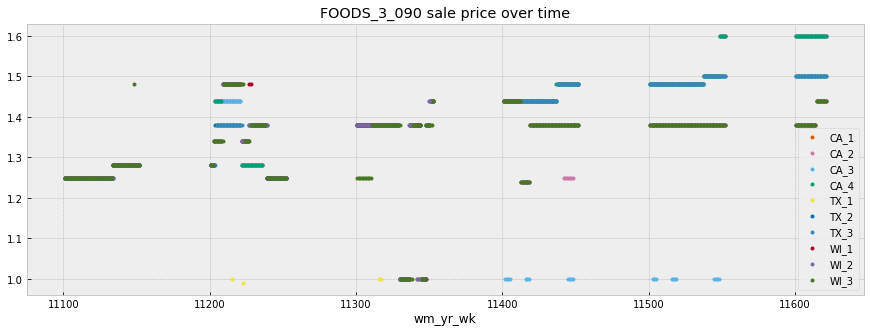

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))
stores = []
for store, d in sell_prices.query('item_id == "FOODS_3_090"').groupby('store_id'):
    d.plot(x='wm_yr_wk',
          y='sell_price',
          style='.',
          color=next(color_cycle),
          figsize=(15, 5),
          title='FOODS_3_090 sale price over time',
         ax=ax,
          legend=store)
    stores.append(store)
    plt.legend()
plt.legend(stores)
plt.show()

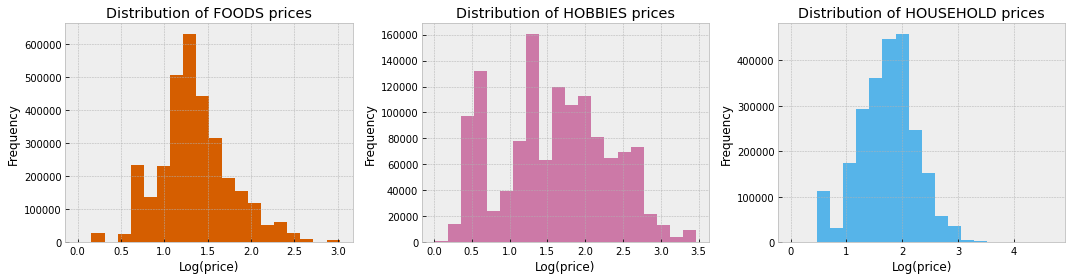

In [40]:
sell_prices['Category'] = sell_prices['item_id'].str.split('_', expand=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
i = 0
for cat, d in sell_prices.groupby('Category'):
    ax = d['sell_price'].apply(np.log1p) \
        .plot(kind='hist',
                         bins=20,
                         title=f'Distribution of {cat} prices',
                         ax=axs[i],
                                         color=next(color_cycle))
    ax.set_xlabel('Log(price)')
    i += 1
plt.tight_layout()

지난 30일간 평균값 제출

In [41]:
thirty_day_avg_map = sales_train_validation.set_index('id')[d_cols[-30:]].mean(axis=1).to_dict()
fcols = [f for f in sample_submission.columns if 'F' in f]
for f in fcols:
    sample_submission[f] = sample_submission['id'].map(thirty_day_avg_map).fillna(0)
    
sample_submission.to_csv('submission.csv', index=False)

To do
- 요일별 과거 평균 판매량에 기초한 단순 예측
- 페이스북 예언자 모델
- 일별 기능 기반 lgbm/xgb 모델

In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [43]:
def downcast_dtypes(df):
  float_cols=[c for c in df if df[c].dtype == 'float64']
  int_cols = [c for c in df if df[c].dtype in ["int64","int32"]]
  df[float_cols]=df[float_cols].astype(np.float32)
  df[int_cols]=df[int_cols].astype(np.int16)
  return df

In [44]:
sales_train_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [45]:
sales_train_validation=downcast_dtypes(sales_train_validation)

In [46]:
sales_train_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int16(1913), object(6)
memory usage: 112.6+ MB


Creating Dataset

In [47]:
sales_train_validation

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,...,0,0,1,1,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,...,0,0,1,1,2,1,4,0,0,2,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,2,1,1,1,1,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


In [48]:
sales_train_validation=sales_train_validation.T

In [49]:
sales_train_validation

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,30465,30466,30467,30468,30469,30470,30471,30472,30473,30474,30475,30476,30477,30478,30479,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,HOBBIES_1_011_CA_1_validation,HOBBIES_1_012_CA_1_validation,HOBBIES_1_013_CA_1_validation,HOBBIES_1_014_CA_1_validation,HOBBIES_1_015_CA_1_validation,HOBBIES_1_016_CA_1_validation,HOBBIES_1_017_CA_1_validation,HOBBIES_1_018_CA_1_validation,HOBBIES_1_019_CA_1_validation,HOBBIES_1_020_CA_1_validation,HOBBIES_1_021_CA_1_validation,HOBBIES_1_022_CA_1_validation,HOBBIES_1_023_CA_1_validation,HOBBIES_1_024_CA_1_validation,HOBBIES_1_025_CA_1_validation,...,FOODS_3_803_WI_3_validation,FOODS_3_804_WI_3_validation,FOODS_3_805_WI_3_validation,FOODS_3_806_WI_3_validation,FOODS_3_807_WI_3_validation,FOODS_3_808_WI_3_validation,FOODS_3_809_WI_3_validation,FOODS_3_810_WI_3_validation,FOODS_3_811_WI_3_validation,FOODS_3_812_WI_3_validation,FOODS_3_813_WI_3_validation,FOODS_3_814_WI_3_validation,FOODS_3_815_WI_3_validation,FOODS_3_816_WI_3_validation,FOODS_3_817_WI_3_validation,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
item_id,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,HOBBIES_1_010,HOBBIES_1_011,HOBBIES_1_012,HOBBIES_1_013,HOBBIES_1_014,HOBBIES_1_015,HOBBIES_1_016,HOBBIES_1_017,HOBBIES_1_018,HOBBIES_1_019,HOBBIES_1_020,HOBBIES_1_021,HOBBIES_1_022,HOBBIES_1_023,HOBBIES_1_024,HOBBIES_1_025,...,FOODS_3_803,FOODS_3_804,FOODS_3_805,FOODS_3_806,FOODS_3_807,FOODS_3_808,FOODS_3_809,FOODS_3_810,FOODS_3_811,FOODS_3_812,FOODS_3_813,FOODS_3_814,FOODS_3_815,FOODS_3_816,FOODS_3_817,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
dept_id,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,...,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3
cat_id,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,...,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS
store_id,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,...,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1909,1,1,1,0,1,0,1,4,0,0,0,0,0,0,0,4,0,0,0,0,0,1,1,0,0,...,0,14,3,0,0,0,0,0,27,0,2,1,0,1,0,4,1,1,0,0,0,0,1,1,0
d_1910,3,0,0,1,2,0,0,6,0,0,0,1,0,0,0,0,0,0,11,0,0,1,1,0,2,...,0,6,0,0,1,0,2,2,29,1,0,1,0,0,0,2,3,3,0,2,1,0,0,0,0
d_1911,0,0,1,3,2,2,0,3,0,2,0,0,0,3,2,15,2,0,4,0,0,0,0,2,2,...,0,0,0,0,0,0,6,1,24,0,0,1,0,0,0,0,1,6,0,3,0,0,0,3,0
d_1912,1,0,1,7,2,0,1,2,0,0,0

In [50]:
sales_train_validations=sales_train_validation.fillna(0)

In [51]:
sales_train_validation=sales_train_validation[6:]

In [52]:
sc = MinMaxScaler(feature_range=(0,1))
sales_train_validation=sc.fit_transform(sales_train_validation)

In [53]:
sales_train_validation

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.3       , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.16666667, ..., 0.        , 0.25      ,
        0.        ],
       [0.2       , 0.        , 0.16666667, ..., 0.05      , 0.08333333,
        0.        ],
       [0.2       , 0.        , 0.16666667, ..., 0.        , 0.25      ,
        0.        ]])

In [54]:
timesteps = 14
x_train = []
y_train = []
for i in range(timesteps, 1913):
    x_train.append(sales_train_validation[i-timesteps:i])
    y_train.append(sales_train_validation[i][0:30490])

In [55]:
x_train=np.array(x_train, dtype='float16')
y_train=np.array(y_train, dtype='float16')

In [56]:
x_train.shape,y_train.shape

((1899, 14, 30490), (1899, 30490))

In [60]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=64, input_shape=(np.array(x_train).shape[1], np.array(x_train).shape[2])))
model.add(tf.keras.layers.Dense(30490))

model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(0.001)
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                7822080   
                                                                 
 dense_1 (Dense)             (None, 30490)             1981850   
                                                                 
Total params: 9,803,930
Trainable params: 9,803,930
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.fit(x_train, y_train, epochs=20, batch_size=10)

Epoch 1/20
190/190 [==============================] - 9s 11ms/step - loss: 0.0140
Epoch 2/20
190/190 [==============================] - 2s 11ms/step - loss: 0.0128
Epoch 3/20
190/190 [==============================] - 2s 11ms/step - loss: 0.0123
Epoch 4/20
190/190 [==============================] - 2s 11ms/step - loss: 0.0122
Epoch 5/20
190/190 [==============================] - 2s 11ms/step - loss: 0.0120
Epoch 6/20
190/190 [==============================] - 2s 11ms/step - loss: 0.0120
Epoch 7/20
190/190 [==============================] - 2s 11ms/step - loss: 0.0119
Epoch 8/20
190/190 [==============================] - 2s 11ms/step - loss: 0.0119
Epoch 9/20
190/190 [==============================] - 2s 11ms/step - loss: 0.0118
Epoch 10/20
190/190 [==============================] - 2s 11ms/step - loss: 0.0118
Epoch 11/20
190/190 [==============================] - 2s 11ms/step - loss: 0.0118
Epoch 12/20
190/190 [==============================] - 2s 11ms/step - loss: 0.0118
Epoch 13/20
1

Test Data

In [62]:
inputs = sales_train_validation[-timesteps:]
inputs = sc.transform(inputs)

In [63]:
inputs

array([[0.        , 0.        , 0.        , ..., 0.01      , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00694444,
        0.        ],
       [0.        , 0.        , 0.02777778, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.02777778, ..., 0.        , 0.02083333,
        0.        ],
       [0.04      , 0.        , 0.02777778, ..., 0.0025    , 0.00694444,
        0.        ],
       [0.04      , 0.        , 0.02777778, ..., 0.        , 0.02083333,
        0.        ]])

In [64]:
x_test = []
x_test.append(inputs[0:timesteps])
x_test=np.array(x_test)

In [65]:
predictions=model.predict(x_test)

In [66]:
predictions=model.predict(x_test)

In [67]:
predictions

array([[0.16700357, 0.0588345 , 0.07815969, ..., 0.03008243, 0.08613479,
        0.12027834]], dtype=float32)

Deep AR

In [68]:
def windowed_dataset(x, window_size, batch_size, shuffle):
  ds = tf.data.Dataset.from_tensor_slices(x)
  ds = ds.window(window_size + 1, shift=1, stride=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  if shuffle:
    ds = ds.shuffle(1000)
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  return ds.batch(batch_size).prefetch(1)
  

In [69]:
import DataFrame as df
#""" Here we get top 10 products with highest sales and plot the sales of these products """
top10_sales = sales_train_validation.df.loc[:,'d_1':'d_1913'].sum(axis=1).sort_values(ascending=False).iloc[:10]
top10_sales_idx = list(top10_sales.index)
top10_sales_df = sales_train_validation.loc[top10_sales_idx]
top10_sales_df = pd.melt(top10_sales_df, id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],
                         var_name='d',value_name='sales')
top10_sales_df = top10_sales_train_validation.merge(calendar_df,on='d',how='left')
top10_sales_df_grp = top10_sales_train_validation.groupby('id')
top10_sales_df_idx = list(top10_sales_df_grp.groups.values())
top_prod = list(top10_sales_df_grp.groups.keys())
top_prod = [x.replace('_validation','') for x in top_prod]

df = top10_sales_df.iloc[top10_sales_df_idx[0]]
df['date'] = pd.to_datetime(df['date'])
top_dates = df['date']
date_format = mat_dates.DateFormatter('%b, %d, %Y')
N = len(top_prod)

hex_color = ['#D636DB','#FF2FA9','#FF6179','#FF9957','#FFCC50','#F9F871','#6968FF','#008888','#5ABAB6','#4D8B31']
color = iter(hex_color)

"""Daily sales pattern of top sales products"""
fig = plt.figure(figsize=(15, 20))
for i in range(N):
    ax = fig.add_subplot(N,1,i+1)
    df1 = top10_sales_df.iloc[top10_sales_df_idx[i]]
    ax.plot_date(top_dates,df1['sales'],linestyle='solid',linewidth=1,marker='.',color=next(color))
    ax.xaxis.set_major_formatter(date_format)
    ax.set_title(top_prod[i]+ ' Sales')
    ax.set_xlabel('All Days from 2011 to 2016')
    ax.set_ylabel('Daily Sales')
plt.tight_layout()
plt.show()

ModuleNotFoundError: ignored

In [ ]:
import os

import warnings
warnings.filterwarnings('ignore')

import pickle

import numpy as np
import pandas as pd
from typing import Dict, Callable, List, Optional, Tuple, Union

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import torch

import pytorch_lightning as pl

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet

In [ ]:
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, DistributionLoss, distributions, BaseEstimator

In [ ]:
class MultivariateDistributionLoss(DistributionLoss):
    """Base class for multivariate distribution losses.
    Class should be inherited for all multivariate distribution losses, i.e. if a batch of values
    is predicted in one go and the batch dimension is not independent, but the time dimension still
    remains independent.
    """

    def sample(self, y_pred, n_samples: int) -> torch.Tensor:
        """
        Sample from distribution.
        Args:
            y_pred: prediction output of network (shape batch_size x n_timesteps x n_paramters)
            n_samples (int): number of samples to draw
        Returns:
            torch.Tensor: tensor with samples  (shape batch_size x n_timesteps x n_samples)
        """
        dist = self.map_x_to_distribution(y_pred)
        samples = dist.sample((n_samples,)).permute(
            2, 1, 0
        )  # returned as (n_samples, n_timesteps, batch_size), so reshape to (batch_size, n_timesteps, n_samples)
        return samples

    def to_prediction(self, y_pred: torch.Tensor) -> torch.Tensor:
        """
        Convert network prediction into a point prediction.
        Args:
            y_pred: prediction output of network
        Returns:
            torch.Tensor: mean prediction
        """
        distribution = self.map_x_to_distribution(y_pred)

        return distribution.mean.transpose(0, 1)  # switch to batch_size x n_timesteps

    def loss(self, y_pred: torch.Tensor, y_actual: torch.Tensor) -> torch.Tensor:
        """
        Calculate negative likelihood
        Args:
            y_pred: network output
            y_actual: actual values
        Returns:
            torch.Tensor: metric value on which backpropagation can be applied
        """
        distribution = self.map_x_to_distribution(y_pred)
        # calculate one number and scale with batch size
        loss = -distribution.log_prob(y_actual.transpose(0, 1)).sum() * y_actual.size(0)
        return loss

In [ ]:
import torch.nn.functional as F
class MultivariateNormalDistributionLoss(MultivariateDistributionLoss):
    """
    Multivariate low-rank normal distribution loss.
    Use this loss to make out of a DeepAR model a DeepVAR network.
    Requirements for original target normalizer:
        * not normalized in log space (use :py:class:`~LogNormalDistributionLoss`)
        * not coerced to be positive
    """

    distribution_class = distributions.LowRankMultivariateNormal

    def __init__(
        self,
        name: str = None,
        quantiles: List[float] = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
        reduction: str = "mean",
        rank: int = 10,
        sigma_init: float = 1.0,
        sigma_minimum: float = 1e-3,
    ):
        """
        Initialize metric
        Args:
            name (str): metric name. Defaults to class name.
            quantiles (List[float], optional): quantiles for probability range.
                Defaults to [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98].
            reduction (str, optional): Reduction, "none", "mean" or "sqrt-mean". Defaults to "mean".
            rank (int): rank of low-rank approximation for covariance matrix. Defaults to 10.
            sigma_init (float, optional): default value for diagonal covariance. Defaults to 1.0.
            sigma_minimum (float, optional): minimum value for diagonal covariance. Defaults to 1e-3.
        """
        super().__init__(name=name, quantiles=quantiles, reduction=reduction)
        self.rank = rank
        self.sigma_minimum = sigma_minimum
        self.sigma_init = sigma_init
        self.distribution_arguments = list(range(2 + rank))

        # determine bias
        self._diag_bias: float = self.inv_softplus(self.sigma_init**2) if self.sigma_init > 0.0 else 0.0

    def map_x_to_distribution(self, x: torch.Tensor) -> distributions.Normal:
        x = x.permute(1, 0, 2)
        return self.distribution_class(
            loc=x[..., 0],
            cov_factor=x[..., 2:],
            cov_diag=x[..., 1],
        )

    @staticmethod
    def validate_encoder(encoder: BaseEstimator):
        assert encoder.transformation not in [
            "log",
            "log1p",
        ], "Use MultivariateLogNormalDistributionLoss for log scaled data"  # todo: implement
        assert encoder.transformation not in [
            "softplus",
            "relu",
        ], "Cannot use NormalDistributionLoss for positive data"
        assert encoder.transformation not in ["logit"], "Cannot use bound transformation such as 'logit'"

    def rescale_parameters(
        self, parameters: torch.Tensor, target_scale: torch.Tensor, encoder: BaseEstimator
    ) -> torch.Tensor:
        self.validate_encoder(encoder)

        # scale
        loc = encoder(dict(prediction=parameters[..., 0], target_scale=target_scale)).unsqueeze(-1)
        scale = (
            F.softplus(parameters[..., 1].unsqueeze(-1) + self._diag_bias) + self.sigma_minimum**2
        ) * target_scale[..., 1, None, None] ** 2

        cov_factor = parameters[..., 2:] * target_scale[..., 1, None, None]
        return torch.concat([loc, scale, cov_factor], dim=-1)

    def inv_softplus(self, y):
        if y < 20.0:
            return np.log(np.exp(y) - 1.0)
        else:
            return y

### Data 생성


In [ ]:
with open('crypto_currency.pickle', 'rb') as f:
  data = pickle.load(f)

In [ ]:
data['KRW-BTT'].head(3)

In [ ]:
[x for (x, y) in data.items() if len(y) == 720]

In [ ]:
d1 = data['KRW-ZIL']

In [ ]:
d1 = d1.sort_values('candle_date_time_kst')

In [ ]:
d1['time_index'] = np.arange(len(d1))

In [ ]:
date_index = d1[['time_index', 'candle_date_time_kst']]

In [ ]:
date_index.head()

In [ ]:
res_data = pd.DataFrame()
scalers = {}

for i, key in enumerate(data.keys()):
  tmp = data[key]
  tmp_1 = pd.merge(tmp, date_index, on = 'candle_date_time_kst')
  tmp_df_1 = tmp_1[['time_index', 'candle_date_time_kst', 'market']]

  # Scaling
  scaler = MinMaxScaler()
  scale_col = ['candle_acc_trade_volume', 'trade_price']
  scaled = scaler.fit_transform(tmp[scale_col])
  tmp_df_2 = pd.DataFrame(scaled, columns = ['candle_acc_trade_volume', 'trade_price'])
  tmp_res = pd.concat([tmp_df_1, tmp_df_2], axis = 1)

  res_data = pd.concat([res_data, tmp_res])
  scalers[key] = scaler

In [ ]:

res_data.shape

In [ ]:
res_data[res_data['time_index'].isna()]

In [ ]:
res_data.dropna(inplace = True)

In [ ]:
res_data['time_index'] = res_data['time_index'].astype(int)

In [ ]:
res_data.shape

In [ ]:
max_encoder_length = 60
max_prediction_length = 20
training_cutoff = res_data['time_index'].max() - max_prediction_length

In [ ]:
training_cutoff

In [ ]:
training = TimeSeriesDataSet(
  res_data[lambda x: x.time_index <= training_cutoff],
  time_idx = 'time_index',
  target = 'trade_price',
  categorical_encoders = {'market': NaNLabelEncoder().fit(res_data.market)},
  group_ids = ['market'],
  time_varying_unknown_reals = ['trade_price'],
  # time_varying_known_reals = ['candle_acc_trade_volume'],
  max_encoder_length = max_encoder_length,
  max_prediction_length = max_prediction_length,
  allow_missing_timesteps = True
)

In [ ]:
validation = TimeSeriesDataSet.from_dataset(
    training,
    res_data,
    min_prediction_idx = training_cutoff + 1
)

In [ ]:
batch_size = 128
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 0)

### Calculate baseline errror

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

In [ ]:
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus = 1, gradient_clip_val = .1)
net = DeepAR.from_dataset(
    training, 
    learning_rate = 3e-2, 
    hidden_size = 200, 
    rnn_layers = 2, 
   loss = MultivariateNormalDistributionLoss()
)

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor()

In [ ]:
trainer = pl.Trainer(
    max_epochs = 10,
    gpus = 1,
    weights_summary = 'top', ##
    gradient_clip_val = .01,
    callbacks = [lr_logger, early_stop_callback],
    limit_train_batches = 30,
    enable_checkpointing = True,
    # auto_lr_find = True
)

In [ ]:
trainer.fit(
    net,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader,
)

In [ ]:
best_model_path

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = net.load_from_checkpoint(best_model_path)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = net.predict(val_dataloader)
(actuals - predictions).abs().mean()

In [ ]:
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

In [ ]:
raw_predictions, x = net.predict(val_dataloader, mode = 'raw', return_x=True, n_samples=100)

In [ ]:
# for idx in range(2):  # plot 10 examples
for i in range(10):
    net.plot_prediction(x, raw_predictions, idx=i, add_loss_to_title=True)

In [ ]:
raw_predictions, x = net.predict(val_dataloader, return_x=True, n_samples=100)
for i in np.arange(60, 70):
    plt.figure(figsize=(4, 3))
    plt.plot(raw_predictions[i], label='prediction')
    plt.plot(actuals[i], label='actual')
    plt.suptitle('Timeseries Prediction')
    plt.legend()
    plt.show()